In [1]:
import os
import sys
sys.path.append("/users/ziyzhang/topology-research")
from topologies.DDF import DDFtopo
# from nexullance.Nexullance_OPT import Nexullance_OPT
from nexullance.Nexullance_MP import Nexullance_MP
sys.path.append("/users/ziyzhang/topology-research/nexullance/IT_boost/build")
from Nexullance_IT_cpp import Nexullance_IT_interface
import globals as gl
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
config = (36,5)
V = config[0]
D = config[1]
EPR = (D+1)//2
_network = DDFtopo(V, D)
arcs = _network.generate_graph_arcs()

ASP, _ = _network.calculate_all_shortest_paths()
ECMP_ASP = gl.ECMP(ASP)

Cap_remote = 10 #GBps
Cap_local = 10 #GBps


In [3]:
Shift_MEPs = []
Shift_ECMP_phis = []
# illustrating the traffic demand matrices:
# # generate a figure that will show the heapmaps of M_Rs for different shifts
# plt.figure(figsize=(10, 20))
for _shift in range(1, V*EPR):
    M_EP = gl.generate_shift_traffic_pattern(V, EPR, _shift)
    # try to scale the traffic scaling factor to 10x saturation under ECMP_ASP
    remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(ECMP_ASP, EPR, M_EP)
    max_remote_link_load = np.max(remote_link_flows)/Cap_remote
    max_local_link_load = np.max(local_link_flows)/Cap_local
    traffic_scaling = 10.0/max(max_local_link_load, max_remote_link_load)
    M_EP = traffic_scaling * M_EP
    M_R = gl.convert_M_EPs_to_M_R(M_EP, V, EPR)
    Shift_MEPs.append(M_EP)
    remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(ECMP_ASP, EPR, M_EP)
    max_remote_link_load = np.max(remote_link_flows)/Cap_remote
    max_local_link_load = np.max(local_link_flows)/Cap_local

    Shift_ECMP_phis.append(gl.network_total_throughput(M_EP, max_remote_link_load, max_local_link_load)/(EPR*V))

    # # use plt to generate heapmap for M_R, as a subfigure of the figure
    # plt.subplot(V*EPR, 1, _shift)
    # plt.imshow(M_R, cmap='viridis', aspect='equal', vmax= 65)
    # plt.title(f'Shift {_shift}')
    # plt.xlabel('dest Router id')
    # plt.ylabel('src Router id')
    # plt.colorbar()

# plt.suptitle("Family Photo of 'shift' traffic demand matrices for a (6,2) DDF network", fontsize=16, y= 1.0)
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(4, 4))
M_EP = gl.generate_uniform_traffic_pattern(V, EPR)
# try to scale the traffic scaling factor to 10x saturation under ECMP_ASP
remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(ECMP_ASP, EPR, M_EP)
max_remote_link_load = np.max(remote_link_flows)/Cap_remote
max_local_link_load = np.max(local_link_flows)/Cap_local
traffic_scaling = 10.0/max(max_local_link_load, max_remote_link_load)
Uniform_MEP = traffic_scaling * M_EP
Uniform_MR = gl.convert_M_EPs_to_M_R(Uniform_MEP, V, EPR)
# # use plt to generate heapmap for M_R, as a subfigure of the figure
# plt.xlabel('dest Router id')
# plt.ylabel('src Router id')
# plt.imshow(Uniform_MR, cmap='viridis', aspect='equal', vmax= 65)
# plt.title(f'Uniform traffic demand matrix')
# plt.colorbar()


In [4]:
Shift_ECMP_phis

[5.0,
 2.5,
 1.6666666666666667,
 1.6666666666666663,
 1.6666666666666663,
 1.6666666666666667,
 1.4285714285714282,
 1.25,
 1.1111111111111114,
 1.25,
 1.1111111111111112,
 0.8333333333333334,
 0.9523809523809524,
 1.111111111111111,
 0.9523809523809524,
 1.176470588235294,
 1.4285714285714286,
 1.6666666666666667,
 1.4285714285714286,
 1.25,
 1.1111111111111114,
 1.1538461538461542,
 1.2,
 1.1111111111111114,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111114,
 1.25,
 1.4285714285714286,
 1.6666666666666667,
 1.4285714285714286,
 1.25,
 1.1111111111111114,
 1.1428571428571426,
 1.176470588235294,
 1.1111111111111114,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111114,
 1.25,
 1.4285714285714282,
 1.6666666666666667,
 1.5789473684210529,
 1.5,
 1.4285714285714286,
 1.7647058823529411,
 2.142857142857143,
 1.6666666666666667,
 1.7142857142857142,
 1.5584415584415585,
 1.4285714285714282,
 1.5789473684210529,
 1.7647058823529411,
 1.6666666666666667,
 1.76470588235

In [5]:
remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(ECMP_ASP, EPR, Uniform_MEP)
max_local_link_load = np.max(local_link_flows)/Cap_local
max_remote_link_load = np.max(remote_link_flows)/Cap_remote
Uniform_ECMP_phi = gl.network_total_throughput(Uniform_MEP, max_remote_link_load, max_local_link_load)/(EPR*V)
# nexu = Nexullance_OPT(_network.nx_graph, Uniform_MEP, Cap_remote, 0, False)
# nexu.init_model()
# Lremote_NEXU_OPT = nexu.solve()
# Uniform_OPT_phi = gl.network_total_throughput(Uniform_MEP, Lremote_NEXU_OPT, max_local_link_load)/(V*EPR)

# run Nexullance_MP
APST4, _ = _network.calculate_all_paths_within_length(4)
nexu = Nexullance_MP(_network.nx_graph, APST4, gl.convert_M_EPs_to_M_R(Uniform_MEP, V, EPR), Cap_remote, 0, False)
nexu.init_model()
Lremote_NEXU, _ = nexu.solve()
Uniform_MP_phi = gl.network_total_throughput(Uniform_MEP, Lremote_NEXU, max_local_link_load)/(V*EPR)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2411299
Academic license 2411299 - for non-commercial use only - registered to zi___@ugent.be
Set parameter Threads to value 1
Optimal solution found


In [14]:
Uniform_MP_phi

7.178857797414499

In [ ]:
# run Nexullance_IT
nexu_it = Nexullance_IT_interface(V, arcs, gl.convert_M_EPs_to_M_R(Uniform_MEP, V, EPR), False)
# nexu_it.set_parameters(4.6419767269134455, 6.593203706205871)
nexu_it.run()
Lremote_NEXU = nexu_it.get_max_link_load()
Uniform_IT_phi = gl.network_total_throughput(Uniform_MEP, Lremote_NEXU, max_local_link_load)/(V*EPR)

In [15]:
Uniform_IT_phi

5.442695312822819

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv("/users/ziyzhang/topology-research/Nexullance_journal_data_gen/MD_Nexullance/DDF/DDF_36_5_MD_all_shifts.csv")

In [8]:
plot_data={}
for i, _ in enumerate(Shift_MEPs):
    _shift = i+1
    raw_data = df[(df["included_M_R"]==f"shift_{_shift}")]
    plot_data[f"shift_{_shift}"] = [raw_data["Phi_MP"].values[0]/(V*EPR), raw_data["Phi_MD_MP"].values[0]/(V*EPR), 
                                    raw_data["Phi_IT"].values[0]/(V*EPR), raw_data["Phi_MD_IT"].values[0]/(V*EPR)]


In [9]:
data_matrix=[]
for i, _ in enumerate(Shift_MEPs):
    _shift = i+1
    data_matrix.append(plot_data[f"shift_{_shift}"])

data_matrix=np.array(data_matrix).transpose()

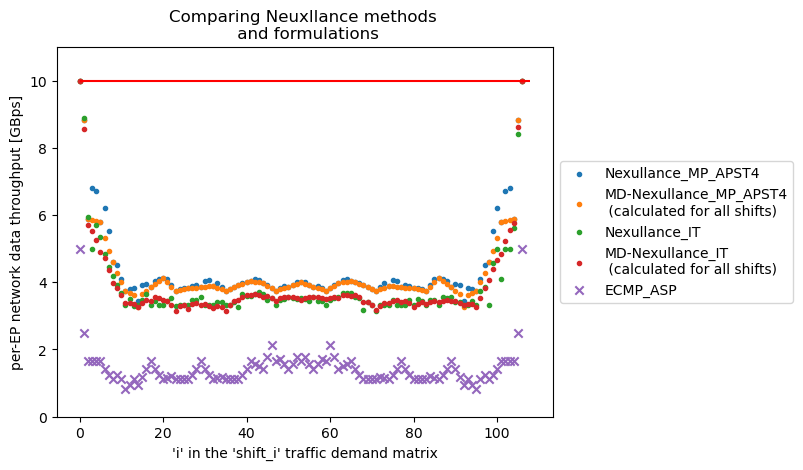

In [20]:
methods= ['Nexullance_MP_APST4', 'MD-Nexullance_MP_APST4\n (calculated for all shifts)', 'Nexullance_IT', 'MD-Nexullance_IT\n (calculated for all shifts)']
for i in range(data_matrix.shape[0]):
    plt.scatter(np.arange(data_matrix.shape[1]), data_matrix[i], label=methods[i], marker='.')
plt.scatter(np.arange(len(Shift_ECMP_phis)), Shift_ECMP_phis, label='ECMP_ASP', marker='x')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.0, 11.0)
plt.xlabel("'i' in the 'shift_i' traffic demand matrix")
plt.ylabel("per-EP network data throughput [GBps]")
plt.title("Comparing Neuxllance methods \n and formulations")
plt.hlines(10.0, 0, V*EPR, colors="red")

In [11]:
import matplotlib.cm as cm
def plot_bench_bars(_data: dict, methods_name: list, title: str, x_label: str, y_label: str, y_log: bool = False, normalized: bool = False, _figsize=(15, 3)):

    # Calculate bar width dynamically based on the number of methods
    num_methods = len(methods_name)
    bar_width = 0.7 / num_methods  # Adjust this scaling factor as needed

    # Generating x positions for each group of bars
    x_positions = np.arange(len(_data))  

    # Generate colors using a predefined colormap
    colors = cm.tab10(np.linspace(0, 1, num_methods))

    # Plotting
    plt.figure(figsize=_figsize)  # Adjust size if necessary

    margin = 0.5
    plt.hlines(10.0, x_positions[0]-margin, x_positions[-1]+margin, colors="red")

    for i, method in enumerate(methods_name):
        # Extracting performance metrics for each method
        performance = [_data[bench][i] for bench in _data]
        # Adjusting x positions for each group of bars
        x_positions_adjusted = x_positions + (i - num_methods//2) * bar_width
        # Plotting bars for each method
        plt.bar(x_positions_adjusted, performance, width=bar_width, align='center', label=method, color = colors[i])
    # Adding labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # if normalized:
    #     plt.ylim(0, 1)
    if y_log:
        plt.yscale("log")  
    plt.title(title)

    x_ticks = [key.replace("_", "-") for key in _data.keys()]
    # x_ticks = [key.replace("-", "-\n") if key != "shift-1" else key for key in x_ticks]
    plt.xticks(x_positions, x_ticks)
    # Moving the legend outside the figure to the right
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)    
    plt.tight_layout()
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(x_positions[0]-margin, x_positions[-1]+margin)
    # plt.ylim(0, 11)

    # Show plot
    plt.show()

In [12]:
MD_MP_routing_table = pickle.load(open("./MD_NEXU_MP_APST_all_shifts_(36,5)DDFtopo_paths.pickle", 'rb'))
MD_IT_routing_table = pickle.load(open("./MD_NEXU_IT_all_shifts_(36,5)DDFtopo_paths.pickle", 'rb'))

remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(MD_MP_routing_table, EPR, M_EP)
max_local_link_load = np.max(local_link_flows)/Cap_local
max_remote_link_load = np.max(remote_link_flows)/Cap_remote
MD_MP_uniform_phi = gl.network_total_throughput(M_EP, max_remote_link_load, max_local_link_load)/(V*EPR)

remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(MD_IT_routing_table, EPR, M_EP)
max_local_link_load = np.max(local_link_flows)/Cap_local
max_remote_link_load = np.max(remote_link_flows)/Cap_remote
MD_IT_uniform_phi = gl.network_total_throughput(M_EP, max_remote_link_load, max_local_link_load)/(V*EPR)

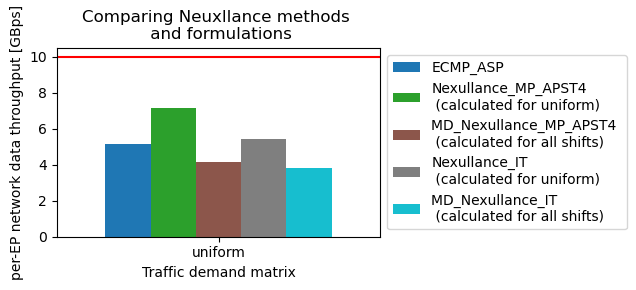

In [13]:
plot_data={}
plot_data["uniform"]=[Uniform_ECMP_phi,  Uniform_MP_phi,MD_MP_uniform_phi,Uniform_IT_phi,MD_IT_uniform_phi]

methods = ['ECMP_ASP', 'Nexullance_MP_APST4\n (calculated for uniform)', 'MD_Nexullance_MP_APST4 \n (calculated for all shifts)', 
           'Nexullance_IT\n (calculated for uniform)', 'MD_Nexullance_IT \n (calculated for all shifts)']
plot_bench_bars(plot_data, methods, "Comparing Neuxllance methods \n and formulations", 
                "Traffic demand matrix", "per-EP network data throughput [GBps]", y_log=False, normalized=False, _figsize=(4,3))